# Spatial analysis of POIs

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from cenpy import products
import statsmodels.api as sm
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import os
os.chdir('../')

In [3]:
from roc_bike_growth.loader import POI_graph_from_polygon, bike_infra_from_polygon, carall_from_polygon, _fill_edge_geometry
from roc_bike_growth.plotting import add_categorical_legend

In [4]:
from roc_bike_growth.settings import CONFIG

In [5]:
rochester = ox.geocode_to_gdf('rochester, ny').geometry[0]

In [6]:
# Grab pois snapped to carall infra
carall = carall_from_polygon(rochester, add_pois=True)
pois = list(nx.get_node_attributes(carall, 'poi').keys())
poi_gdf = ox.utils_graph.graph_to_gdfs(carall.subgraph(pois), nodes=True, edges=False)

Exception at Port of Rochester, Lake Ave . This point will be dropped:
 Nominatim could not geocode query "Port of Rochester, Lake Ave  rochester ny"
Exception at 810-846 N GOODMAN ST. This point will be dropped:
 Nominatim could not geocode query "810-846 N GOODMAN ST rochester ny"
Exception at 650-672 E Main St. This point will be dropped:
 Nominatim could not geocode query "650-672 E Main St rochester ny"
Exception at 497-499 S. CLINTON. This point will be dropped:
 Nominatim could not geocode query "497-499 S. CLINTON rochester ny"


## Census api stuff


In [7]:
# from https://api.census.gov/data/2019/acs/acs5/variables.html
variables = {
    'B01001_001E': 'total_population', #

    # Income
    'B17001_001E': 'income_poverty_total', #POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE
    'B17001_002E': 'income_poverty_yes', #POVERTY STATUS IN THE PAST 12 MONTHS BY AGE BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 5 YEARS AND OVER
    
    # Education
    'B16010_001E': 'edu_total',
    'B16010_002E': 'edu_lt_high_school',
    
    # Vehicles available
    'B08141_001E': 'vehicle_available_total',
    'B08141_002E': 'vehicle_available_none',

    # Race
    'B02001_001E': 'race_total',
    'B02001_002E': 'race_white',
    'B02001_003E': 'race_black_or_african_american',
    'B02001_004E': 'race_american_indian_or_pacific_islander',
    'B02001_005E': 'race_asian',
    'B02001_006E': 'race_hawaiian',
    'B02001_007E': 'race_other',
    'B02001_008E': 'race_two_or_more',   
}

In [8]:
# Download variables of interest from ACS
df_raw = products.ACS(2019).from_county('Monroe, NY', level='tract',
                                        variables=list(variables.keys()))

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.9/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county

In [9]:
# Process the dataframe and join POIs
gdf = (df_raw
       .rename(columns=variables)
       .to_crs('EPSG:4326')
      )

gdf = gdf.assign(area_km_sq=gdf.to_crs(32117).area/1000)
gdf = gdf.assign(
          population_density = gdf['total_population']/gdf['area_km_sq'],
          income_poverty_pct = gdf['income_poverty_yes']/gdf['income_poverty_total'],
          edu_lt_high_school_pct = gdf['edu_lt_high_school']/gdf['edu_total'],
          vehicle_available_none_pct = gdf['vehicle_available_none']/gdf['vehicle_available_total'],
          race_non_white_pct = 1-(gdf['race_white']/gdf['race_total'])
      )
poi_by_tract = (poi_gdf
                .sjoin(
                    gdf[['GEOID','geometry']], 
                    how='left',
                    predicate='within')
                .groupby('GEOID')
                .count()['poi']
                .rename('poi_count')
                .fillna(0))

gdf = gdf.join(poi_by_tract, on='GEOID')
gdf = gdf.loc[gdf.within(rochester.buffer(0.01))]

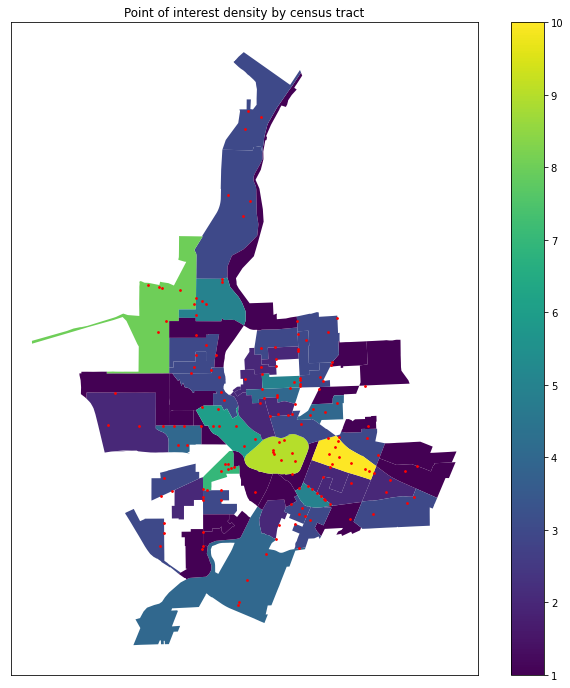

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
gdf.plot(column='poi_count', legend=True, ax=ax)
poi_gdf.plot(ax=ax, markersize=3, color='red')
plt.xticks([])
plt.yticks([])
plt.title('Point of interest density by census tract')
plt.savefig('poi_by_census.png')

In [11]:
cols = ['total_population','income_poverty_pct','edu_lt_high_school_pct','vehicle_available_none_pct','race_non_white_pct','population_density','area_km_sq','poi_count']

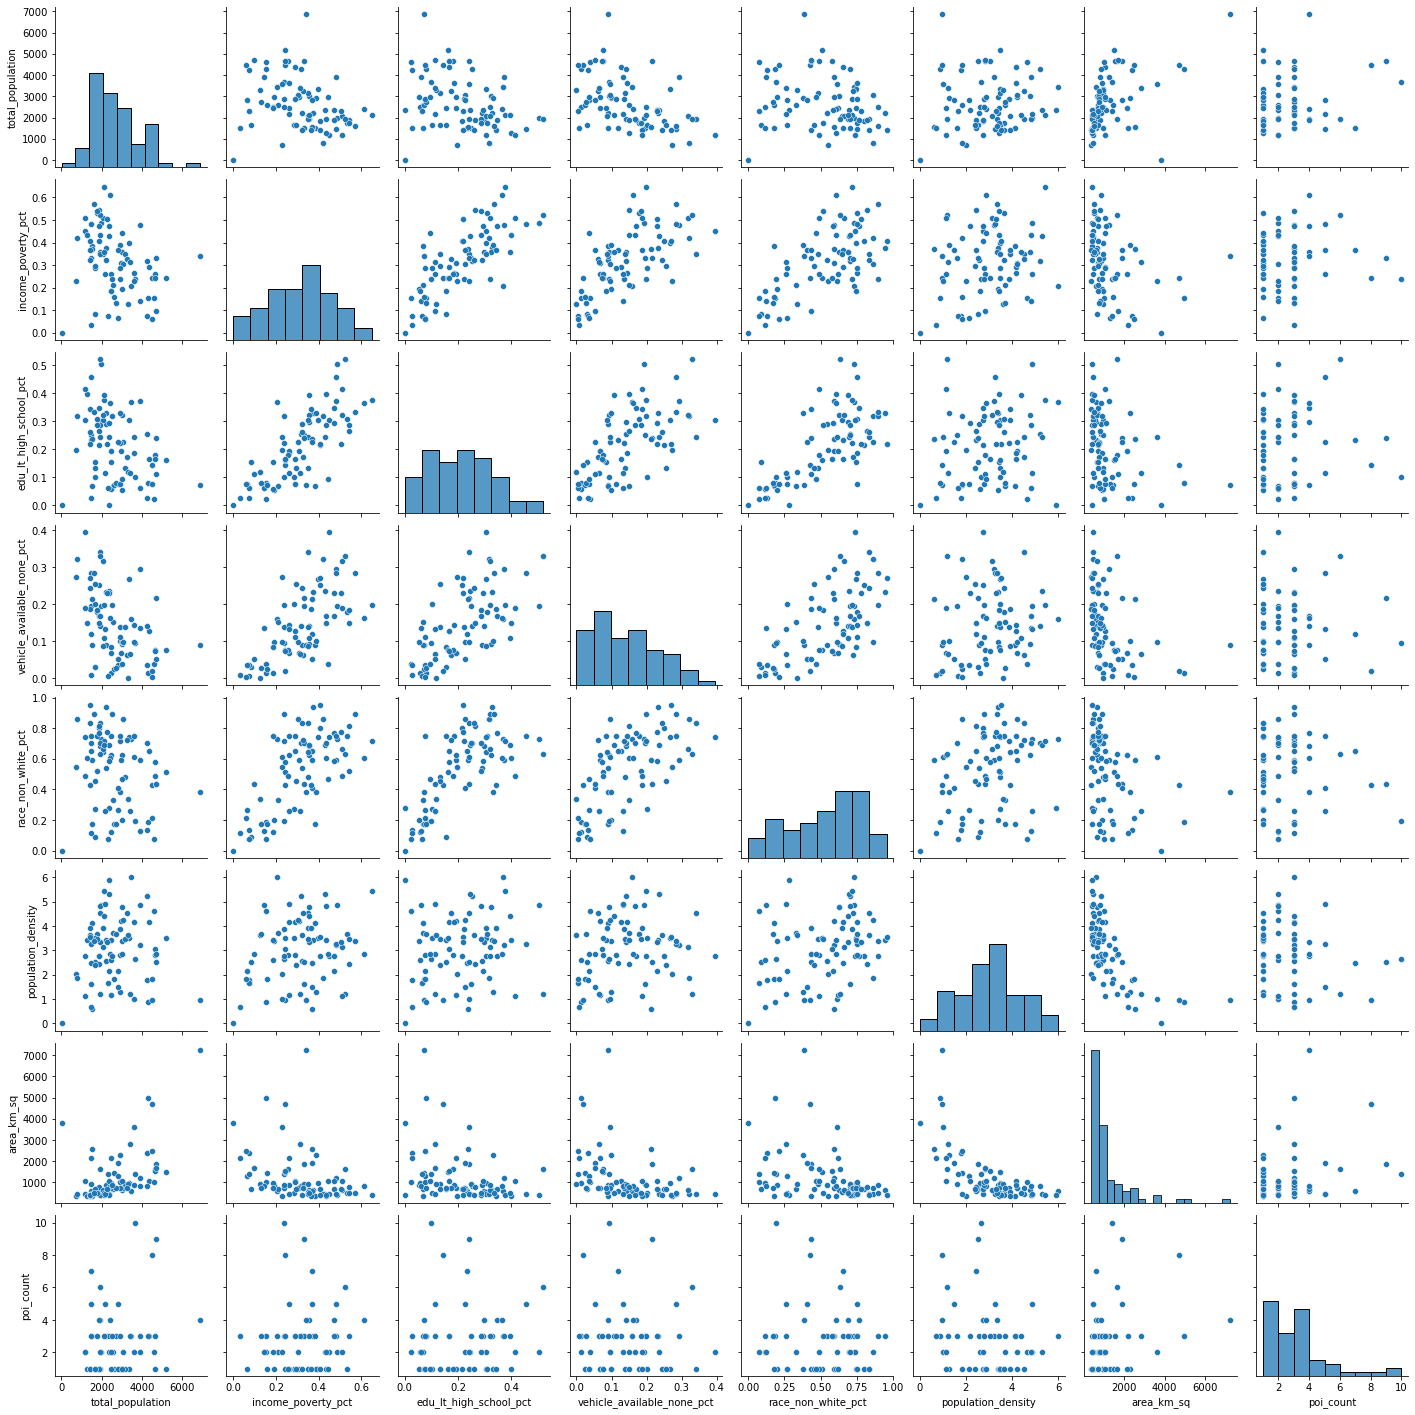

In [12]:
sns.pairplot(data=gdf[cols])

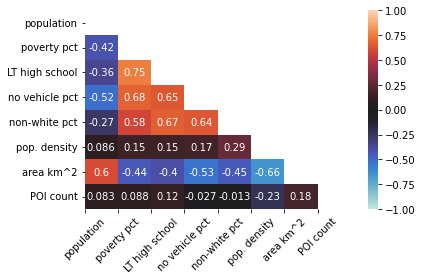

In [13]:
labels=['population','poverty pct','LT high school','no vehicle pct','non-white pct','pop. density','area km^2','POI count']

corr = gdf[cols].corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0, mask=mask)
plt.yticks(ticks=np.arange(0.5, len(labels)),labels=labels)
plt.xticks(rotation=45, ticks=np.arange(0,len(labels)), labels=labels)
plt.tight_layout()
plt.savefig('poi_corrplot.png')

## Compare across quadrants

In [14]:
quadrants=gpd.read_file('data/city_quadrants')

In [15]:
# Note that census tract -> quadrant mappings here aren't perfect
quad_df = (quadrants
           # join POI counts
           .join(
                other=(poi_gdf
                   .sjoin(quadrants[['Quad','geometry']], how='left', predicate='within')
                   .groupby('Quad')['y']
                   .count()
                   .rename('poi_count')
                   ),
                on='Quad')
           # join population
           .join(
               other=(gdf
                      .sjoin(quadrants[['Quad','geometry']].set_geometry(quadrants.buffer(0.008)), how='inner',predicate='within')
                      .groupby('Quad')['total_population']
                      .sum()
                     ),
               on='Quad')
          )

quad_df = quad_df.assign(
    poi_per_capita=quad_df['poi_count']/quad_df['total_population'],
    poi_per_km_sq=quad_df['poi_count']/quad_df['Shape__Are']*1000,)

/tmp/ipykernel_121/2526468580.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .sjoin(quadrants[['Quad','geometry']].set_geometry(quadrants.buffer(0.008)), how='inner',predicate='within')


In [16]:
quad_df[['Quad','poi_count','total_population','poi_per_capita','poi_per_km_sq']].to_csv('poi_by_quadrant.csv')

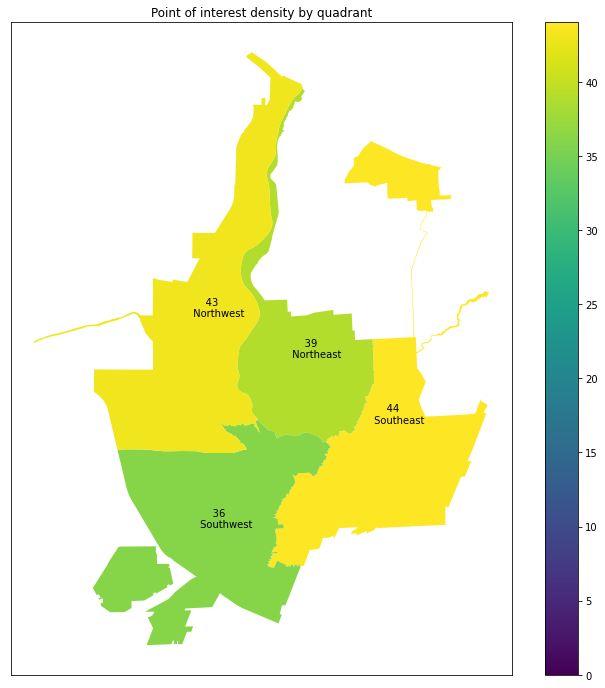

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
quad_df.plot(column='poi_count', legend=True, vmin=0, ax=ax)
for idx, row in quad_df.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x-0.005,y, f"     {row['poi_count']}\n {row['Quad']}")
    
ax.set_xticks([])
ax.set_yticks([])
plt.title('Point of interest density by quadrant')
plt.savefig('poi_by_quadrant.png')